# Recommendation Engine for E-Commerce Sales: Part 3. Build Pipeline

This notebook gives an overview of techniques and services offer by SageMaker to build and deploy a personalized recommendation engine.

## Dataset

The dataset for this demo comes from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Online+Retail). It contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. The following attributes are included in our dataset:
+ InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
+ StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
+ Description: Product (item) name. Nominal.
+ Quantity: The quantities of each product (item) per transaction. Numeric.
+ InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
+ UnitPrice: Unit price. Numeric, Product price per unit in sterling.
+ CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
+ Country: Country name. Nominal, the name of the country where each customer resides. 

Citation: Daqing Chen, Sai Liang Sain, and Kun Guo, Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining, Journal of Database Marketing and Customer Strategy Management, Vol. 19, No. 3, pp. 197â€“208, 2012 (Published online before print: 27 August 2012. doi: 10.1057/dbm.2012.17)

In [1]:
!pip install sagemaker==2.21.0 boto3==1.16.40

In [ ]:
%store -r
%store

In [3]:
import sagemaker
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.steps import CreateModelStep, ProcessingStep, TrainingStep
from sagemaker.workflow.step_collections import RegisterModel
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.workflow.parameters import ParameterInteger, ParameterFloat, ParameterString
import boto3
import time

In [4]:
assert sagemaker.__version__ >= "2.21.0"

In [5]:
region = boto3.Session().region_name
boto3.setup_default_session(region_name=region)
boto_session = boto3.Session(region_name=region)

s3_client = boto3.client("s3", region_name=region)

sagemaker_boto_client = boto_session.client("sagemaker")
sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session, sagemaker_client=sagemaker_boto_client
)
sagemaker_role = sagemaker.get_execution_role()

bucket = sagemaker_session.default_bucket()

prefix = "personalization"

output_prefix = f"s3://{bucket}/{prefix}/output"

## Define Estimator

In [6]:
container = sagemaker.image_uris.retrieve("factorization-machines", region=boto_session.region_name)

fm = sagemaker.estimator.Estimator(
    container,
    sagemaker_role,
    instance_count=1,
    instance_type="ml.c5.xlarge",
    output_path=output_prefix,
    sagemaker_session=sagemaker_session,
)

fm.set_hyperparameters(
    feature_dim=input_dims,
    predictor_type="regressor",
    mini_batch_size=1000,
    num_factors=64,
    epochs=20,
)

## Build Pipeline

Now that we are comfotable with the model that we built.

In [7]:
base_uri = f"s3://{bucket}/data"
input_data_uri = sagemaker.s3.S3Uploader.upload(
    local_path="data/Online Retail.csv", desired_s3_uri=base_uri
)

input_data = ParameterString(name="InputData", default_value=input_data_uri)

In [8]:
model_approval_status = ParameterString(
    name="ModelApprovalStatus", default_value="PendingManualApproval"
)

In [9]:
create_dataset_script_uri = f"s3://{bucket}/{prefix}/code/preprocessing.py"
s3_client.upload_file(
    Filename="preprocessing.py", Bucket=bucket, Key=f"{prefix}/code/preprocessing.py"
)

sklearn_processor = SKLearnProcessor(
    framework_version="0.23-1",
    instance_type="ml.m5.xlarge",
    instance_count=1,
    base_job_name="sklearn-retail-sales-process",
    role=sagemaker_role,
)

create_dataset_step = ProcessingStep(
    name="PreprocessData",
    processor=sklearn_processor,
    inputs=[
        sagemaker.processing.ProcessingInput(
            source=input_data, destination="/opt/ml/processing/input"
        ),
    ],
    outputs=[
        sagemaker.processing.ProcessingOutput(
            output_name="train_data", source="/opt/ml/processing/output/train"
        ),
        sagemaker.processing.ProcessingOutput(
            output_name="test_data", source="/opt/ml/processing/output/test"
        ),
    ],
    code=create_dataset_script_uri,
)

In [10]:
train_step = TrainingStep(
    name="TrainingStep",
    estimator=fm,
    inputs={
        "train": sagemaker.inputs.TrainingInput(
            s3_data=create_dataset_step.properties.ProcessingOutputConfig.Outputs[
                "train_data"
            ].S3Output.S3Uri
        ),
        "test": sagemaker.inputs.TrainingInput(
            s3_data=create_dataset_step.properties.ProcessingOutputConfig.Outputs[
                "test_data"
            ].S3Output.S3Uri
        ),
    },
)

In [11]:
model = sagemaker.model.Model(
    name="retail-personalization-factorization-machine",
    image_uri=train_step.properties.AlgorithmSpecification.TrainingImage,
    model_data=train_step.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=sagemaker_session,
    role=sagemaker_role,
)

inputs = sagemaker.inputs.CreateModelInput(instance_type="ml.m4.xlarge")

create_model_step = CreateModelStep(name="CreateModel", model=model, inputs=inputs)

In [12]:
register_step = RegisterModel(
    name="RegisterModel",
    estimator=fm,
    model_data=train_step.properties.ModelArtifacts.S3ModelArtifacts,
    content_types=["application/x-recordio-protobuf", "application/json"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.medium", "ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    model_package_group_name=mpg_name,
    approval_status=model_approval_status,
)

In [13]:
s3_client.upload_file(Filename="deploy.py", Bucket=bucket, Key=f"{prefix}/code/deploy.py")
deploy_script_uri = f"s3://{bucket}/{prefix}/code/deploy.py"

deployment_processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=sagemaker_role,
    instance_type="ml.t3.medium",
    instance_count=1,
    base_job_name=f"{prefix}-deploy",
    sagemaker_session=sagemaker_session,
)

deploy_step = ProcessingStep(
    name="DeployModel",
    processor=deployment_processor,
    job_arguments=[
        "--model-name",
        create_model_step.properties.ModelName,
        "--region",
        region,
        "--endpoint-instance-type",
        "ml.m4.xlarge",
        "--endpoint-name",
        "retail-recommendation-endpoint",
    ],
    code=deploy_script_uri,
)

In [14]:
pipeline_name = f"PersonalizationDemo"
%store pipeline_name

pipeline = Pipeline(
    name=pipeline_name,
    parameters=[input_data, model_approval_status],
    steps=[create_dataset_step, train_step, create_model_step, register_step, deploy_step],
)

Stored 'pipeline_name' (str)


In [ ]:
pipeline.upsert(role_arn=sagemaker_role)

In [ ]:
start_response = pipeline.start()
start_response.wait()
start_response.describe()

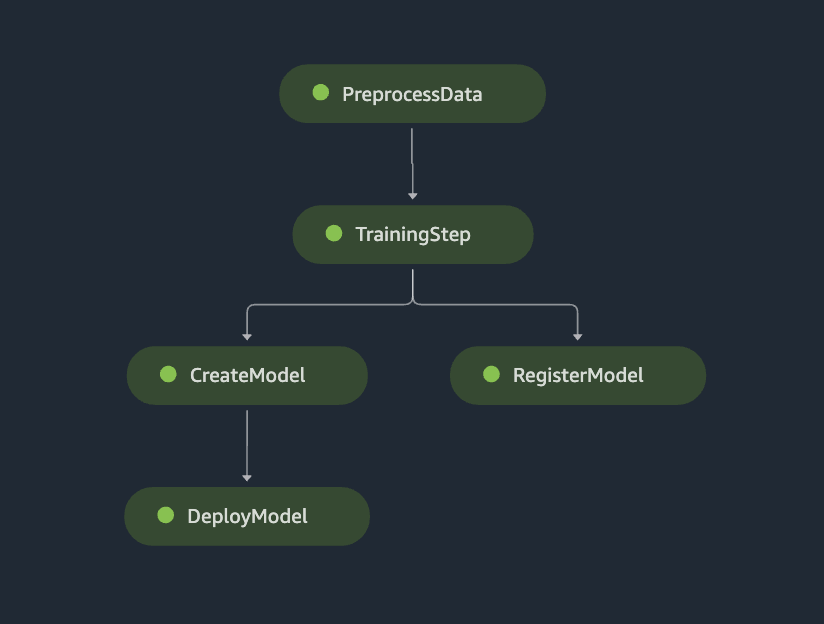

In [ ]:
from sagemaker.lineage.visualizer import LineageTableVisualizer
from pprint import pprint


viz = LineageTableVisualizer(sagemaker_session)
for execution_step in reversed(start_response.list_steps()):
    pprint(execution_step)
    display(viz.show(pipeline_execution_step=execution_step))
    time.sleep(5)